# About log_data_to_sequence

This notebook creates minable sequences from log data given a predetermined translation of log actions to sequence actions.

In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils_timeline_viz
%aimport utils_read_parsing
from utils_timeline_viz import *
from utils_read_parsing import *
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 25, 15
from matplotlib.backends.backend_pdf import PdfPages
import os
import numpy as np
import pandas as pd
import getpass
import datetime
import json
import matplotlib
import matplotlib.pyplot as plt
from itertools import groupby
pd.set_option('display.max_columns', None);pd.set_option('display.max_rows', None);pd.set_option('precision', 2)
# FOLDER =  'C:\\Users\\'+getpass.getuser()+'\\Documents\\Personal Content\\Lab_skills_study\\parsed log data'

# Loading log data


We get all log files per student. They are stored in a dictionary like this:
```python
    log_files_per_sim = {'beers': {student1: [log_file_1.txt,log_file_2.txt], ...
                         'capacitor': {student1: [log_file_1.txt,log_file_2.txt], ...}
```

In [2]:
log_files_per_sim = {}
for sim in ['beers','capacitor']:
    log_files_per_sim[sim] = get_parsed_log_files_per_student_for_sim(sim)

The file Sarah_beers_log_files_per_student.txt has been unpickled and loaded
The file Sarah_capacitor_log_files_per_student.txt has been unpickled and loaded


# Parsing rules

## Load generic rules

In [3]:
rules_beers = pd.read_csv('sequence_parsing_rules_beers.txt', sep='\t')
rules_capacitor = pd.read_csv('sequence_parsing_rules_capacitor.txt', sep='\t')
rules_capacitor_without_state = pd.read_csv('sequence_parsing_rules_capacitor_without_state.txt', sep='\t')

rules_as_dict = {}
rules_as_dict['beers'] = [(rule['Sequence Action'],rule.drop('Sequence Action').dropna().to_dict()) for i,rule in rules_beers.iterrows()]
rules_as_dict['capacitor'] = [(rule['Sequence Action'],rule.drop('Sequence Action').dropna().to_dict()) for i,rule in rules_capacitor.iterrows()]
rules_as_dict['capacitor_without_state'] = [(rule['Sequence Action'],rule.drop('Sequence Action').dropna().to_dict()) for i,rule in rules_capacitor_without_state.iterrows()]

## Parser for cvs_like table actions

In [4]:
regex_pattern_trial = re.compile('trialNumber (\d+)')
def check_cvs_table(row):
    trial_number = int(regex_pattern_trial.match(row['Item']).group(1))
    table = json.loads(row['Table'])

    # if it's the first trial added or the table only has one trial, no possibility for doing cvs
    if trial_number == 1 or len(table)==1:
        return "T_add_first"
    else:
        current_trial = table[str(trial_number)]
        # get trials in table
        all_trial_numbers = table.keys()
        #we iterate through the other trials and check if there is cvs with the current trial
        i=0
        while len(all_trial_numbers)>0:
            some_trial_number = all_trial_numbers.pop()
            if str(some_trial_number) == str(trial_number):
                continue
#                 print some_trial_number, trial_number
            some_trial = table[str(some_trial_number)]
            #we make sets of the all the values of variables between both trials
            values_of_2_points = get_values_per_variable([current_trial, some_trial])
            confounded = pts_are_confounded(values_of_2_points)
            outcomes = get_outcome_values([current_trial, some_trial])
            outcome1,outcome2 = outcomes[0],outcomes[1]
            #we check that only one variable is changed (confounded = False)
            # that the laser was not off, and that the connection wasn't to lightbulb
            # and that the outcome values are not null but floats
            if not confounded and 0 not in values_of_2_points["Laser toggle"] and "LIGHT_BULB_CONNECTED" not in values_of_2_points["Connection"] and isinstance(outcome1, float) and isinstance(outcome2, float):
                return "T_add_cvs"
#             print i, len(all_trial_numbers)
#             i +=1
#             print trial_number, some_trial_number, table
        return "T_add_messy"

For consecutive cvs table add actions:

In [5]:
# regex_pattern_trial = re.compile('trialNumber (\d+)')
# def check_cvs_table(row):
#     if row['Sequence Action']=='table_add':
#         trial_number = int(regex_pattern_trial.match(row['Item']).group(1))
#         table = json.loads(row['Table'])

#         # if it's the first trial added or the table only has one trial, no possibility for doing cvs
#         if trial_number == 1 or len(table)==1:
#             return "table_add_first"
#         else:
#             #the last trial added in table (that still is in table and wasn't deleted) will have the greatest trial number
#             last_trial_number = max([int(key) for key in table.keys() if int(key)!=trial_number])
#             current_trial = table[str(trial_number)]
#             last_trial = table[str(last_trial_number)]
#     #         print trial_number, last_trial_number
#             #we make sets of the all the values of variables between both trials
#             values_of_2_points = get_values_per_variable([current_trial, last_trial])
#     #         print values_of_2_points
#             confounded = pts_are_confounded(values_of_2_points)
#             outcomes = get_outcome_values([current_trial, last_trial])
#             outcome1,outcome2 = outcomes[0],outcomes[1]
#             #we check that only one variable is changed (confounded = False)
#             # that the laser was not off, and that the connection wasn't to lightbulb
#             # and that the outcome values are not null but floats
#             if not confounded and 0 not in values_of_2_points["Laser toggle"] and "LIGHT_BULB_CONNECTED" not in values_of_2_points["Connection"] and isinstance(outcome1, float) and isinstance(outcome2, float):
#                 return "table_add_cvs"
#             else:
#                 return "table_add_messy"
#     else: return row['Sequence Action']

# # row= df.iloc[2387]
# # # row = df.iloc[2438]
# # check_cvs_table(row)

## Parser for cvs_like graph actions

In [6]:
def check_cvs_graph(row):
    table = json.loads(row['Table'])
    points = get_pts(table,in_graph=True) #grab all points in graph
    if len(points)==1:
        return "G_add_first"
#     if row['X axis'] not in ["charge","absorbance"] and row['Y axis'] not in ["charge","absorbance"]:
#         return "G_add_messy"
    values = get_values_per_variable(points)
    confounded = pts_are_confounded(values)
#     print points
    if not confounded and 0 not in values["Laser toggle"] and "LIGHT_BULB_CONNECTED" not in values["Connection"]:
        #We could do some complex things here to check if the right axis was chosen
#         print 'cvs!'
        return "G_add_cvs"
    else:
#         print 'not!'
        return "G_add_messy"

## Parser for time coords

In [7]:
def get_timecoords_blocked_actions(df):
    #reset action timestamps so that the first action starts at time=0
    offset = df.iloc[0]['Time']
    df['Sequence timestamp'] = df['Time']-offset
    #calculate durations of all blocked actions
    df['Sequence timestamp shifted'] = df[['Sequence timestamp']].shift(-1)
    df['Sequence duration'] = df['Sequence timestamp shifted'] - df['Sequence timestamp']
    df['Sequence duration'] = df['Sequence duration'].fillna(1) # the last duration will be NaN so we replace wiht 2 seconds
    #get time coords as a list of tuples [(start_of_action_1, duration_of_action_1), (start_of_action_2, duration_of_action_2),...]
    start_times = list(df['Sequence timestamp'])
    durations = list(df['Sequence duration'])
    return zip(start_times, durations)

## Putting it all together for the parser

In [8]:
def converter(row,rules_as_dict):
    for potential_action,rule in rules_as_dict:
        match=True
        for column,value in rule.iteritems():
            if row[column]!= value:
                match=False
                break
#         if match:
#             if potential_action == 'T_add':
#                 return check_cvs_table(row)
#             if potential_action == 'G_add':
#                 return check_cvs_graph(row)
        if match:
            return potential_action
    else:
        return 'no_match_found'

# Parsing both sims for all students

In [9]:
df_all = get_df_all_factors()

In [10]:
ids = list(set(df_all['sid']))
N = len(ids)
print N

147


## Parsing

Note that students with state data in Capacitors are simply not being parsed.

In [11]:
%%time
all_seqs = {}
all_blocked_seqs = {}
all_blocked_timecoords = {}
for sim in ['capacitor','beers']:
    all_seqs[sim] = {}
    all_blocked_seqs[sim] = {}
    all_blocked_timecoords[sim] = {}
    for student in ids:
        files = log_files_per_sim[sim][student]
        files.sort()
        seq = []
        blocked_seq = []
        timecoords = []
        for f in files:
            df = prep_parsing_data(f) #removes model events, adds pauses with threshold of 9s
            df = df[df['Event']!='dragged'] #remove drag events, keep dragStart and dragEnded
            if df.empty:
                continue
            else:
                df['Sequence Action'] = df.apply(converter, args=([rules_as_dict[sim]]), axis=1)
                if sim=='capacitor' and df['Charge'].isnull().values.any():
                    print "Student {0} has no state data so using special parser".format(student)
                    df['Sequence Action'] = df.apply(converter, args=([rules_as_dict[sim+'_without_state']]), axis=1)
                    
                if df[df['Sequence Action']=='no_match_found'].empty and df['Sequence Action'].isnull().values.any() == False:
                    pass
                else:
                    print "Lack of matches:", df[df['Sequence Action']=='no_match_found']
                    print "NA events:", df[df['Sequence Action'].isnull()].head(1)
                    raise ValueError("some events were not parsed")
            df = df[df['Sequence Action']!='ignore'] #remove ignorable actions
            seq.extend(list(df['Sequence Action']))
            df_blocked = df[(df['Sequence Action'].shift() != df['Sequence Action'])]
            blocked_seq.extend(list(df_blocked['Sequence Action']))
            timecoords.extend(get_timecoords_blocked_actions(df_blocked))
        all_seqs[sim][student] = seq
        all_blocked_seqs[sim][student] = [x
                                          [0] for x in groupby(seq)]
        all_blocked_timecoords[sim][student] = timecoords

utils_timeline_viz.py:96: FutureWarning: read_table is deprecated, use read_csv instead.
  df = pd.read_table(parsing_file, sep='\t')
C:\Users\Sarah\Anaconda2\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Student 23836160 has no state data so using special parser


C:\Users\Sarah\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Sarah\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Sarah\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org

Student 41947147 has no state data so using special parser
Student 11612162 has no state data so using special parser
Student 64006159 has no state data so using special parser
Student 85915167 has no state data so using special parser
Student 11929166 has no state data so using special parser
Student 24511163 has no state data so using special parser
Student 27451164 has no state data so using special parser
Student 90447168 has no state data so using special parser
Student 15055169 has no state data so using special parser
Student 46792161 has no state data so using special parser
Student 24566161 has no state data so using special parser
Student 77047160 has no state data so using special parser
Student 82788161 has no state data so using special parser
Wall time: 4min 33s


## Export parsed sequences

In [12]:
import pickle
#create files
pickle_out_seqs = open(os.path.join(BIG_FOLDER,'all_massaged_data\\dict_by_sim_by_student_parsed_seqs.txt'),"wb")
pickle_out_blocked_seqs = open(os.path.join(BIG_FOLDER,'all_massaged_data\\dict_by_sim_by_student_parsed_blocked_seqs.txt'),"wb")
pickle_out_all_blocked_timecoords = open(os.path.join(BIG_FOLDER,'all_massaged_data\\dict_by_sim_by_student_parsed_blocked_timecoords.txt'),"wb")
#dump data
pickle.dump(all_seqs, pickle_out_seqs)
pickle.dump(all_blocked_seqs, pickle_out_blocked_seqs)
pickle.dump(all_blocked_timecoords, pickle_out_all_blocked_timecoords)
#close files
pickle_out_seqs.close()
pickle_out_blocked_seqs.close()
pickle_out_all_blocked_timecoords.close()

# Load pickled file

In [13]:
import pickle
pickle_in_seqs = open(os.path.join(BIG_FOLDER,'all_massaged_data\\dict_by_sim_by_student_parsed_seqs.txt'),"r")
pickle_in_blocked_seqs = open(os.path.join(BIG_FOLDER,'all_massaged_data\\dict_by_sim_by_student_parsed_blocked_seqs.txt'),"r")
pickle_in_all_blocked_timecoords = open(os.path.join(BIG_FOLDER,'all_massaged_data\\dict_by_sim_by_student_parsed_blocked_timecoords.txt'),"r")
all_seqs = pickle.load(pickle_in_seqs)
all_blocked_seqs = pickle.load(pickle_in_blocked_seqs)
all_blocked_timecoords = pickle.load(pickle_in_all_blocked_timecoords)
pickle_in_seqs.close()
pickle_in_blocked_seqs.close()
pickle_in_all_blocked_timecoords.close()

# Test on 1 student

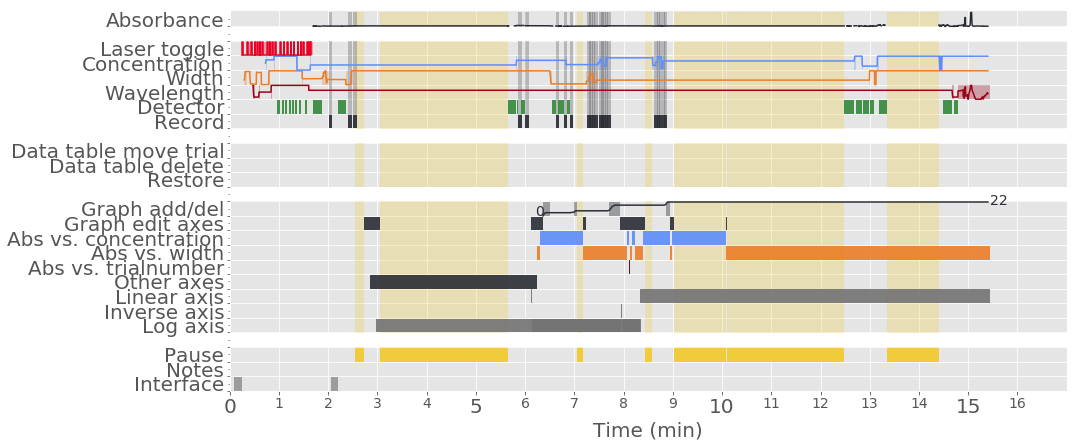

In [14]:
sim = 'beers'
to_plot = to_plot_beers
test_sid = 19989152
df = prep_parsing_data(log_files_per_sim[sim][test_sid][0]) 
plt.figure(figsize=(15,7))
plot(df,to_plot,family_name_to_code,function_to_use,colors)

In [15]:
all_blocked_seqs[sim][test_sid]

['V_other',
 'V_width',
 'T_add',
 'V_other',
 'V_width',
 'T_add',
 'V_width',
 'T_add',
 'P',
 'G_axis_concentration',
 'G_axis_trialnumber',
 'G_axis_width',
 'G_axis_trialnumber',
 'G_scale_inverse',
 'G_scale_log',
 'G_scale_inverse',
 'G_scale_log',
 'P',
 'V_other',
 'V_concentration',
 'V_other',
 'T_add',
 'V_other',
 'T_add',
 'G_scale_inverse',
 'G_scale_linear',
 'G_scale_log',
 'G_axis_outcome',
 'G_axis_concentration',
 'G_add',
 'V_width',
 'V_other',
 'T_add',
 'V_other',
 'T_add',
 'V_concentration',
 'V_other',
 'T_add',
 'G_add',
 'P',
 'G_axis_trialnumber',
 'V_width',
 'T_add',
 'V_width',
 'T_add',
 'V_width',
 'T_add',
 'V_width',
 'T_add',
 'V_width',
 'V_concentration',
 'T_add',
 'V_concentration',
 'T_add',
 'V_concentration',
 'T_add',
 'V_concentration',
 'T_add',
 'V_concentration',
 'T_add',
 'G_add',
 'G_scale_log',
 'G_scale_inverse',
 'G_scale_log',
 'G_axis_concentration',
 'G_axis_width',
 'G_axis_trialnumber',
 'G_axis_concentration',
 'G_scale_log'

# Descriptives of blocked seqs

## Individual actions

In [18]:
nb_use = {}
actions = ['V_width','V_wavelength','V_other','V_concentration','V_battery','T_remove','T_add','P','G_scale_log','G_scale_linear','G_scale_inverse','G_remove','G_axis_width','G_axis_trialnumber','G_axis_outcome','G_axis_concentration','G_add','G_add_fail','G_axis_area','G_axis_separation','P_notes','T_move','T_restore','V_area','V_lightbulb','V_separation']

for a in actions:
    nb_use[a] = []
    for sim in ['beers','capacitor']:
        for student, seq in all_blocked_seqs[sim].iteritems():
            nb_use[a].append(seq.count(a))
actions.sort()

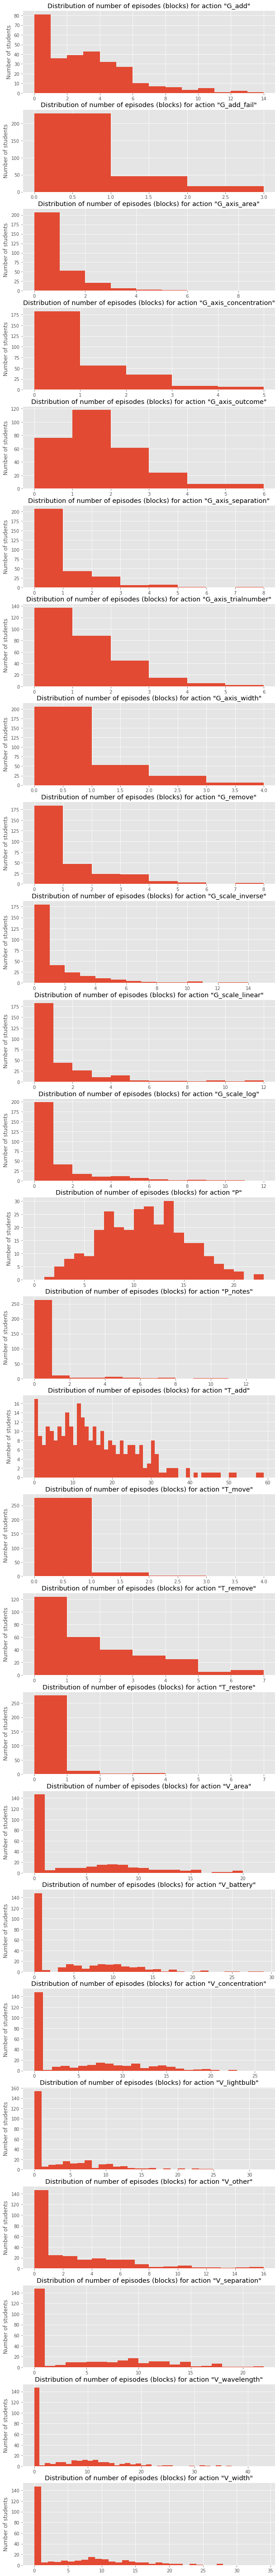

In [19]:
fig,axes = plt.subplots(nrows=len(actions),ncols=1,figsize=(10,4*len(actions)))
for i,a in enumerate(actions):
    ax=axes[i]
#     print a
    (n, bins, patches) = ax.hist(nb_use[a],bins=range(max(nb_use[a])))
    ax.set(title='Distribution of number of episodes (blocks) for action "{0}"'.format(a))
    ax.set(ylabel='Number of students')
#     print a, bins, n

In [20]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('seq_actions_hist_both_sims.pdf') as pdf:
    for i,a in enumerate(actions):
        plt.hist(nb_use[a],bins=range(max(nb_use[a])))
        plt.title('Hist of number of episodes (blocks) for "{0}"'.format(a))
        plt.ylabel('Number of students')
        plt.tight_layout()
        pdf.savefig()
        plt.close()

## Lengths

In [ ]:
# lengths = [len(all_blocked_seqs['beers'][sid]) for sid in all_blocked_seqs['beers'].keys()]

# to do
* unblock certain actions?